In [53]:
# Import all the necessary libraries 
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm_notebook
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
register_matplotlib_converters ()
from time import time

# Importing SafeMed's Sales Data

 RESMEAN:2709206.45202266, OBSMEAN:23178834.207395833, PERC:11.68827745080559%


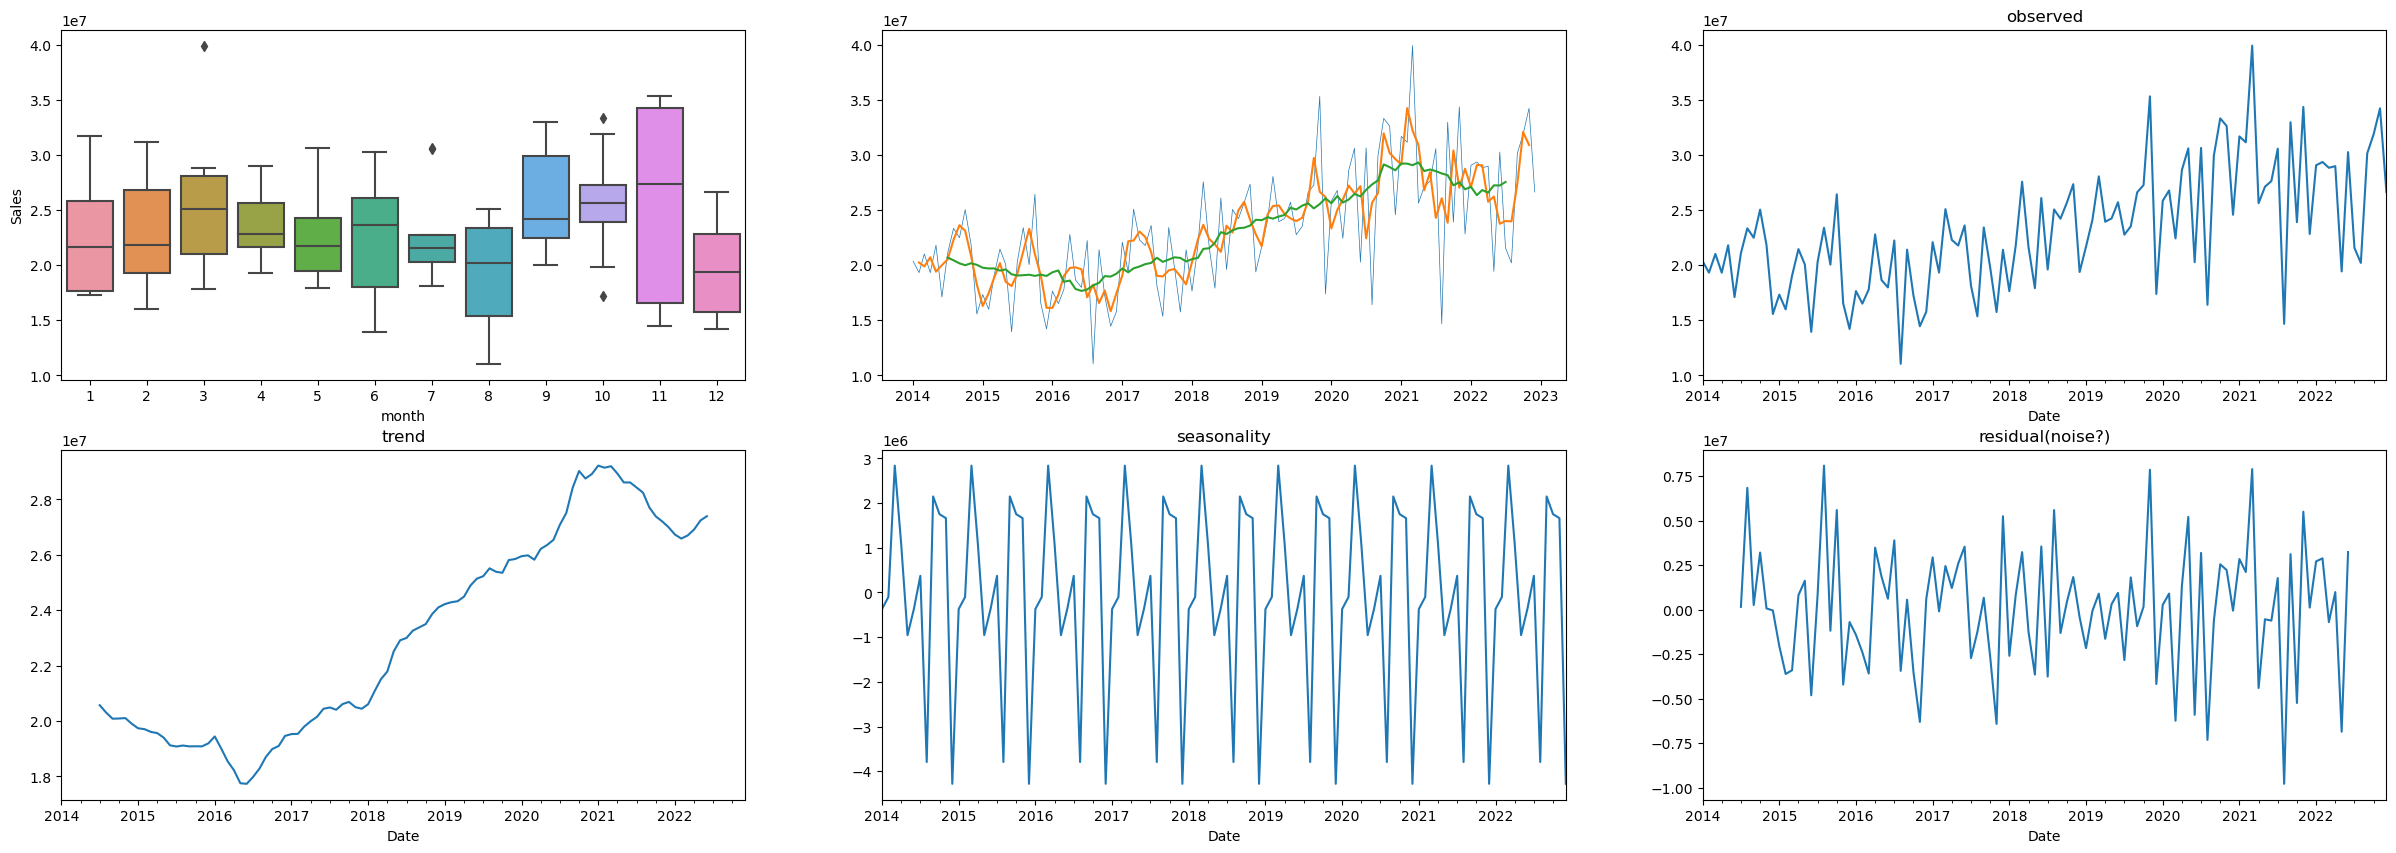

In [59]:
cutoff_train_test = 12

df = pd.read_excel("data_full.xlsx", parse_dates=True,usecols = "A,B").set_index('Date')
df['month'] = df.index.month
df['quarter'] = df.index.quarter

start_date = df.index.min()
end_date = df.index.max()

fig, axes = plt.subplots(2, 3, figsize=(30, 10))

sns.boxplot(data=df, x='month', y='Sales', ax=axes[0,0])
df12mean = df['Sales'].rolling(window=12, center=True).mean()
df12std = df['Sales'].rolling(window=12, center=True).std()
df3mean = df['Sales'].rolling(window=3, center=True).mean()
df3std = df['Sales'].rolling(window=3, center=True).std()

axes[0,1].plot(df['Sales'], linewidth=0.5, label='Monthly sales')
axes[0,1].plot(df3mean, label='3-month rolling mean')
axes[0,1].plot(df12mean, label='12 months rolling mean')

result = seasonal_decompose(df['Sales'], period=12, filt=None)
result.trend.plot(ax=axes[1,0], title='trend')
result.seasonal.plot(ax=axes[1,1], title='seasonality')
result.resid.plot(ax=axes[1,2], title='residual(noise?)')
result.observed.plot(ax=axes[0,2], title='observed')

# Decompose time series into additive model
dfs = pd.concat([result.trend, result.seasonal, result.resid, result.observed], axis=1)
dfs.columns = ['trend', 'seasonal', 'residuals', 'observed']
dfs=dfs.dropna()
res=dfs['residuals'].values
obs=dfs['observed'].values
resmean=np.mean(np.abs(res))
obsmean=np.mean(np.abs(obs))
perc=resmean*100/obsmean
print(' RESMEAN:'+str(resmean)+', OBSMEAN:'+str(obsmean)+', PERC:'+str(perc)+'%')

df=df[['Sales']]

array([<AxesSubplot:title={'center':'Sales'}>], dtype=object)

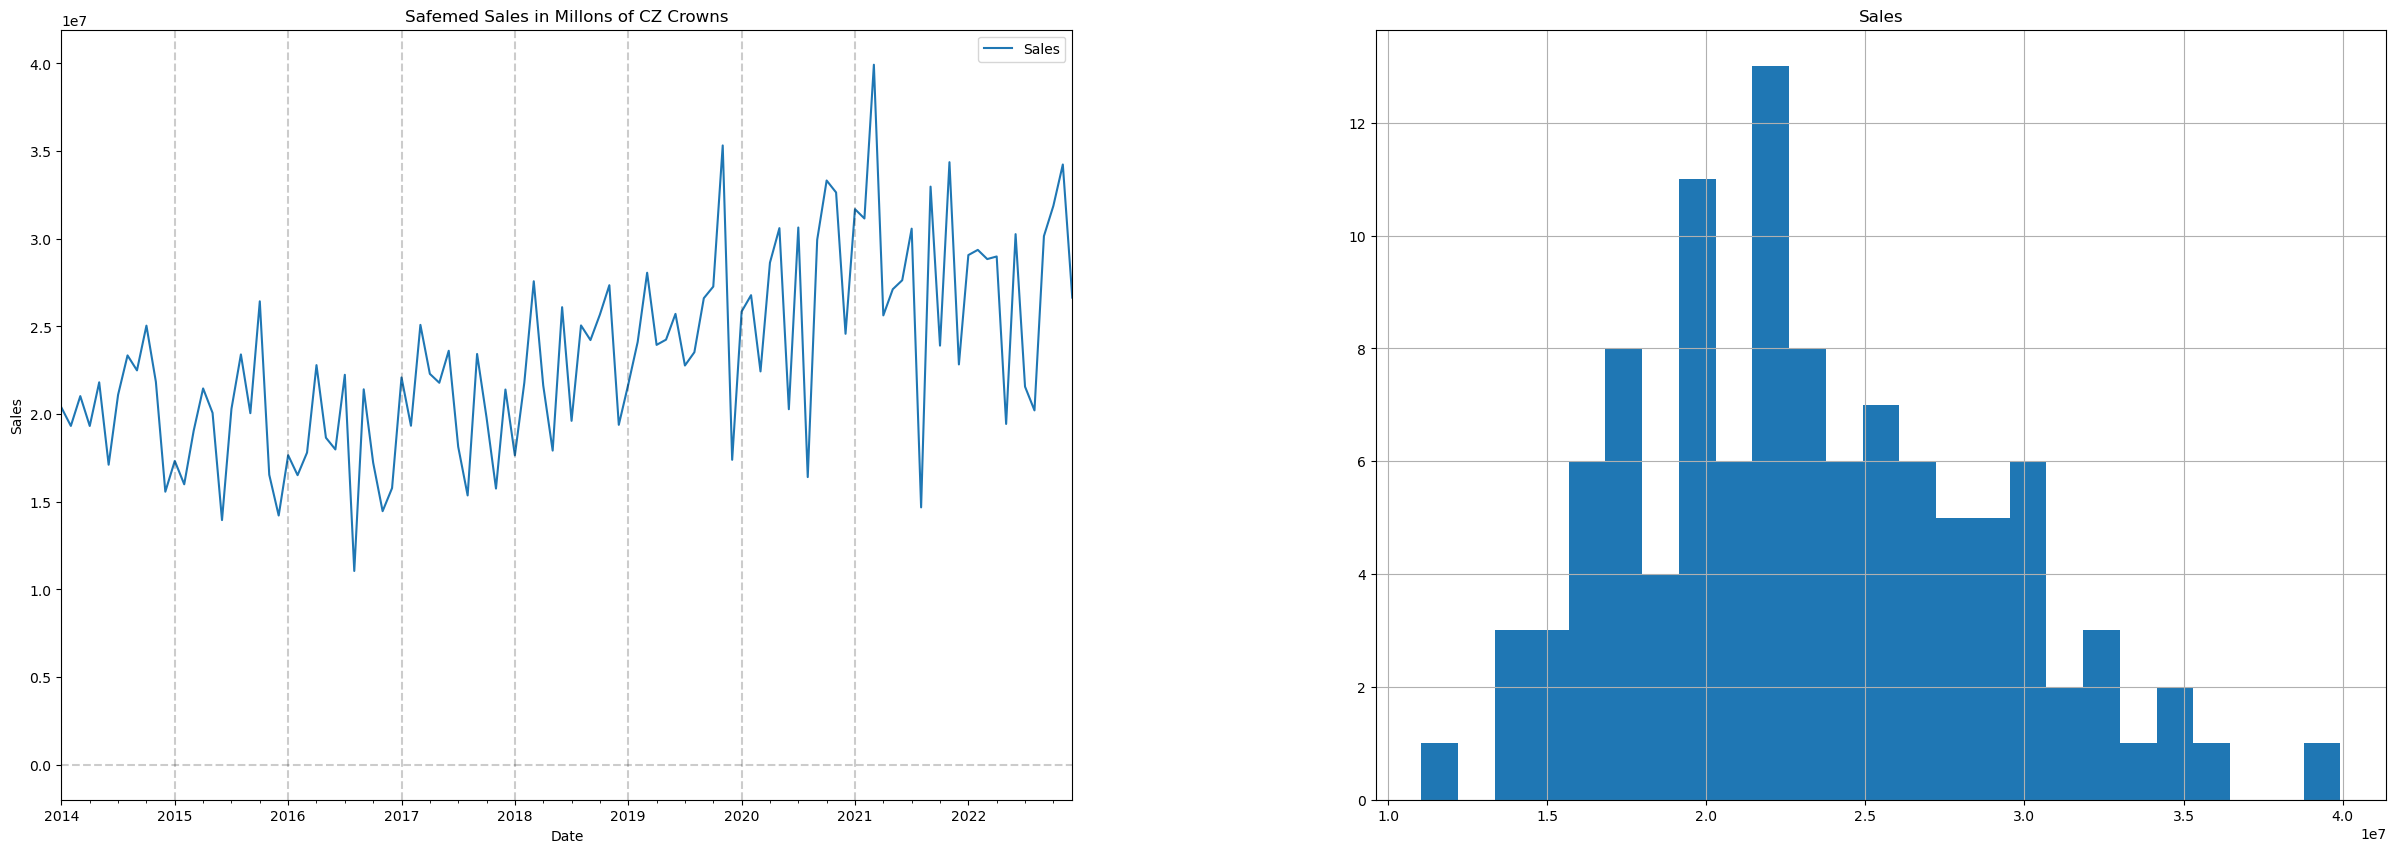

<Figure size 1000x400 with 0 Axes>

In [60]:
# plot the sales data 
fig, axes = plt.subplots(1, 2, figsize=(30, 10))

plt.figure(figsize=(10,4))
df.plot(ax = axes[0], title='Safemed Sales in Millons of CZ Crowns', ylabel='Sales')
for year in range(start_date.year,end_date.year):
    axes[0].axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
axes[0].axhline(0, color='k', linestyle='--', alpha=0.2)
df.hist(bins=25, ax=axes[1])

# We can see that sales of the company is close to a normal distribution. 
# Therefore, we do not have to take log values of the  "sales" 

Clearly, the time series is not stationary, as its mean is not constant through time, and we see an increasing variance in the data, a sign of heteroscedasticity.


Above we can detect weak trend = changing µ
in 2014 -2018 the µ = 2 mln 
from 2019 to 2021 the µ = 2.5 mln 

proving that we are dealing with non stationary time series 

We know that  timeseries has to fulfil 3 main properties ( covariance stationary  processes)

1) E(Yt) = µt =µ   # expected value of Y does not depend on time (constant over time)

2) Cov ( Yt, Yt-1 or future values) # the covariance between Yt and its past or future values also does not depend on time 

3) p(tao) =w(tao)/w(0)= w(tao)/ v(Yt)   # correlation of Yt with its displaced value divided by Yt is also a constant number and it is also does not depend on t 



# Remove the trend in order to obtain a covariance stationary data 



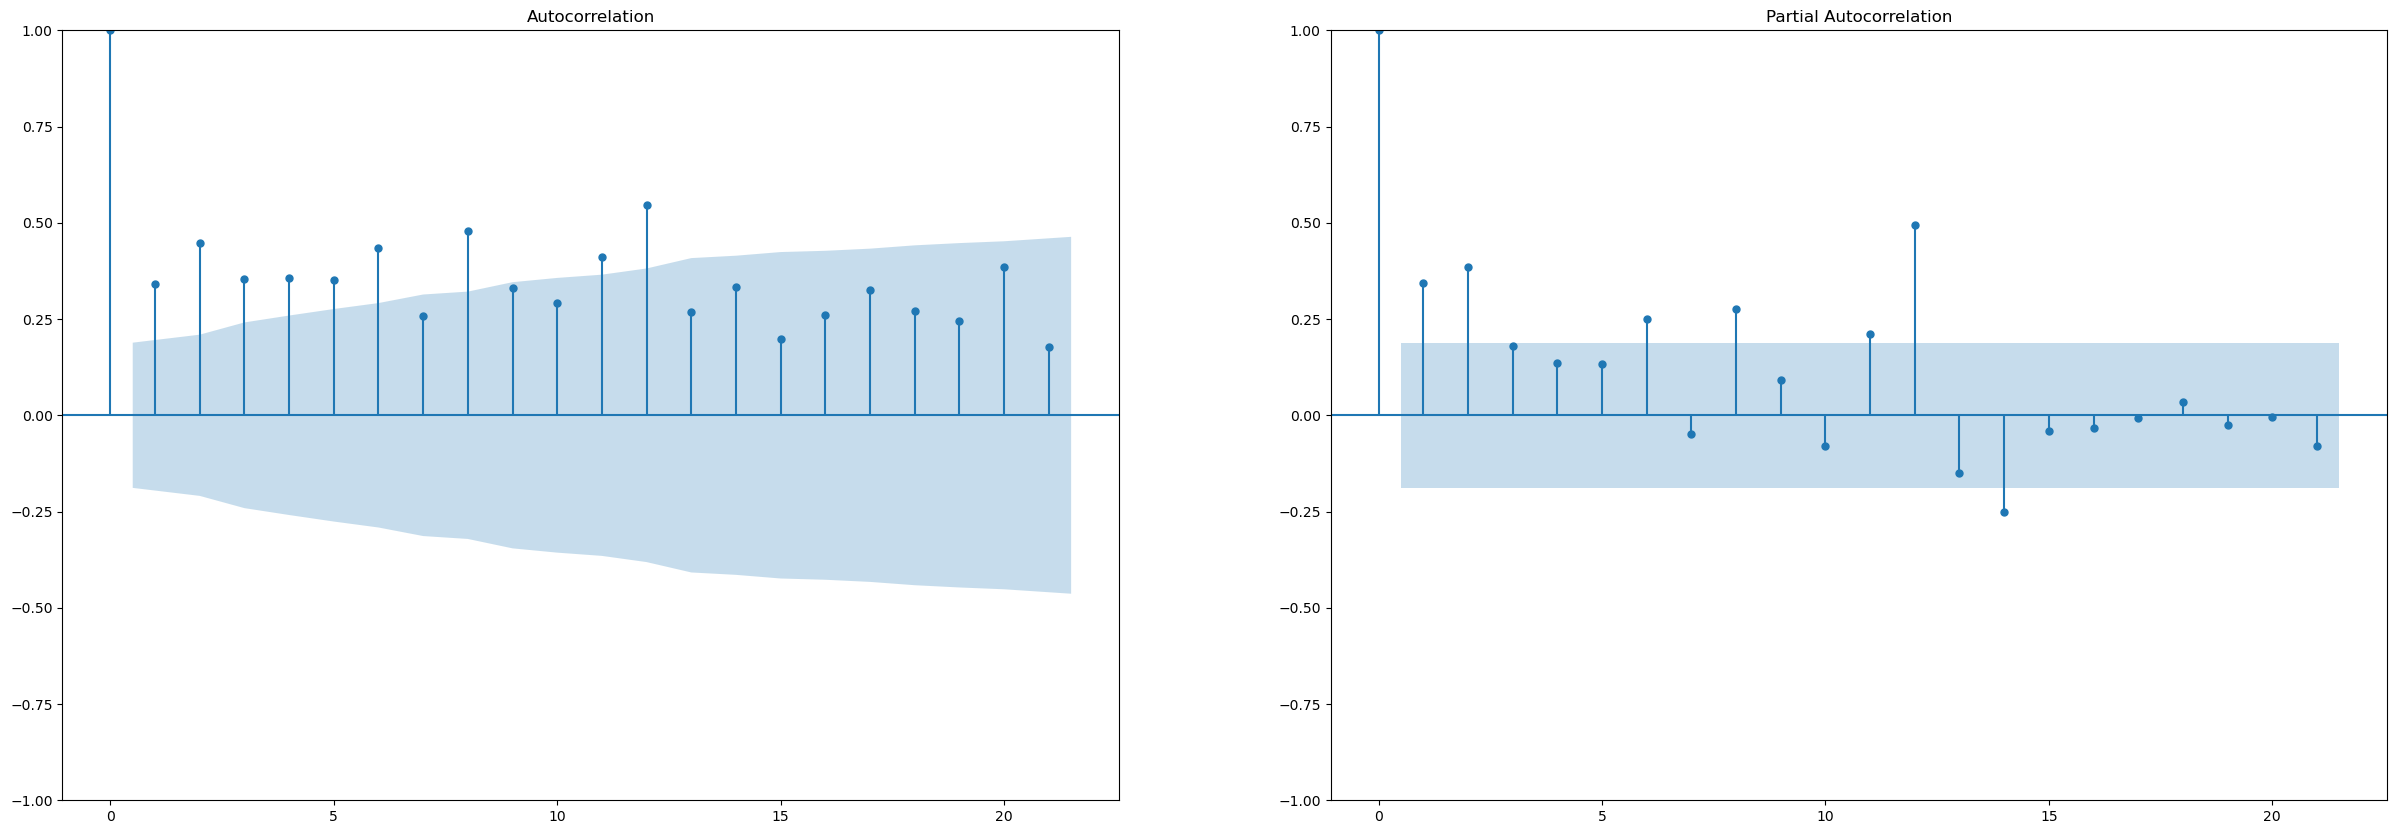

In [27]:
# Now we can check for ACF
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(30, 10))

plot_acf(df.Sales, ax=axes[0]);
plot_pacf(df.Sales, ax=axes[1]);


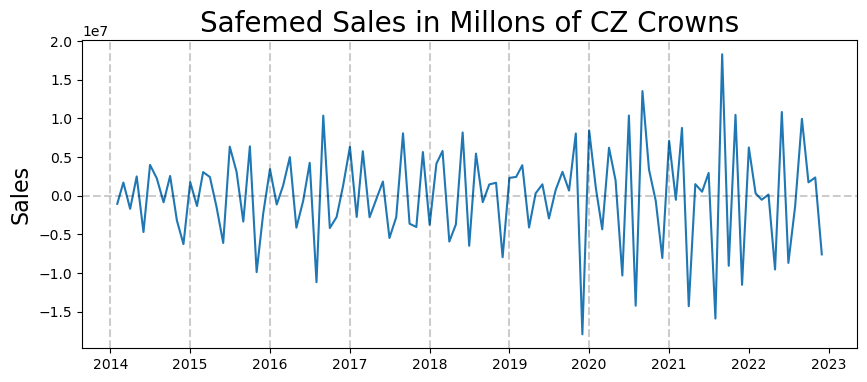

In [28]:
# We can see that timeseries are not stationary, so we try to take a first difference to make it stationary 
first_diff = df.diff()[1:]

plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Safemed Sales in Millons of CZ Crowns', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

# unit root test 

In [31]:
# Mathematical test  can be employed as well. 
# We will test for stationarity using Augmented Dickey Fuller test 
# H0: the given ts is not covariance  stationary 
# HA: the given ts is covariance stationary 
from statsmodels.tsa.stattools import adfuller
result= adfuller(df.Sales.dropna())
print('p-value of the sales without differencing:', result[1])

result= adfuller(first_diff.Sales.diff().dropna())
print('p-value of the sales with first order differencing:', result[1])

# For without differencing, we fail to reject the Null. 
# However for 1st order differenced TS we reject the Null and our data is stationary ( p_value < 5%)

p-value of the sales without differencing: 0.8810838871989548
p-value of the sales with first order differencing: 1.3139783701413726e-10


#  Selecting the Lag order 

# ACF

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

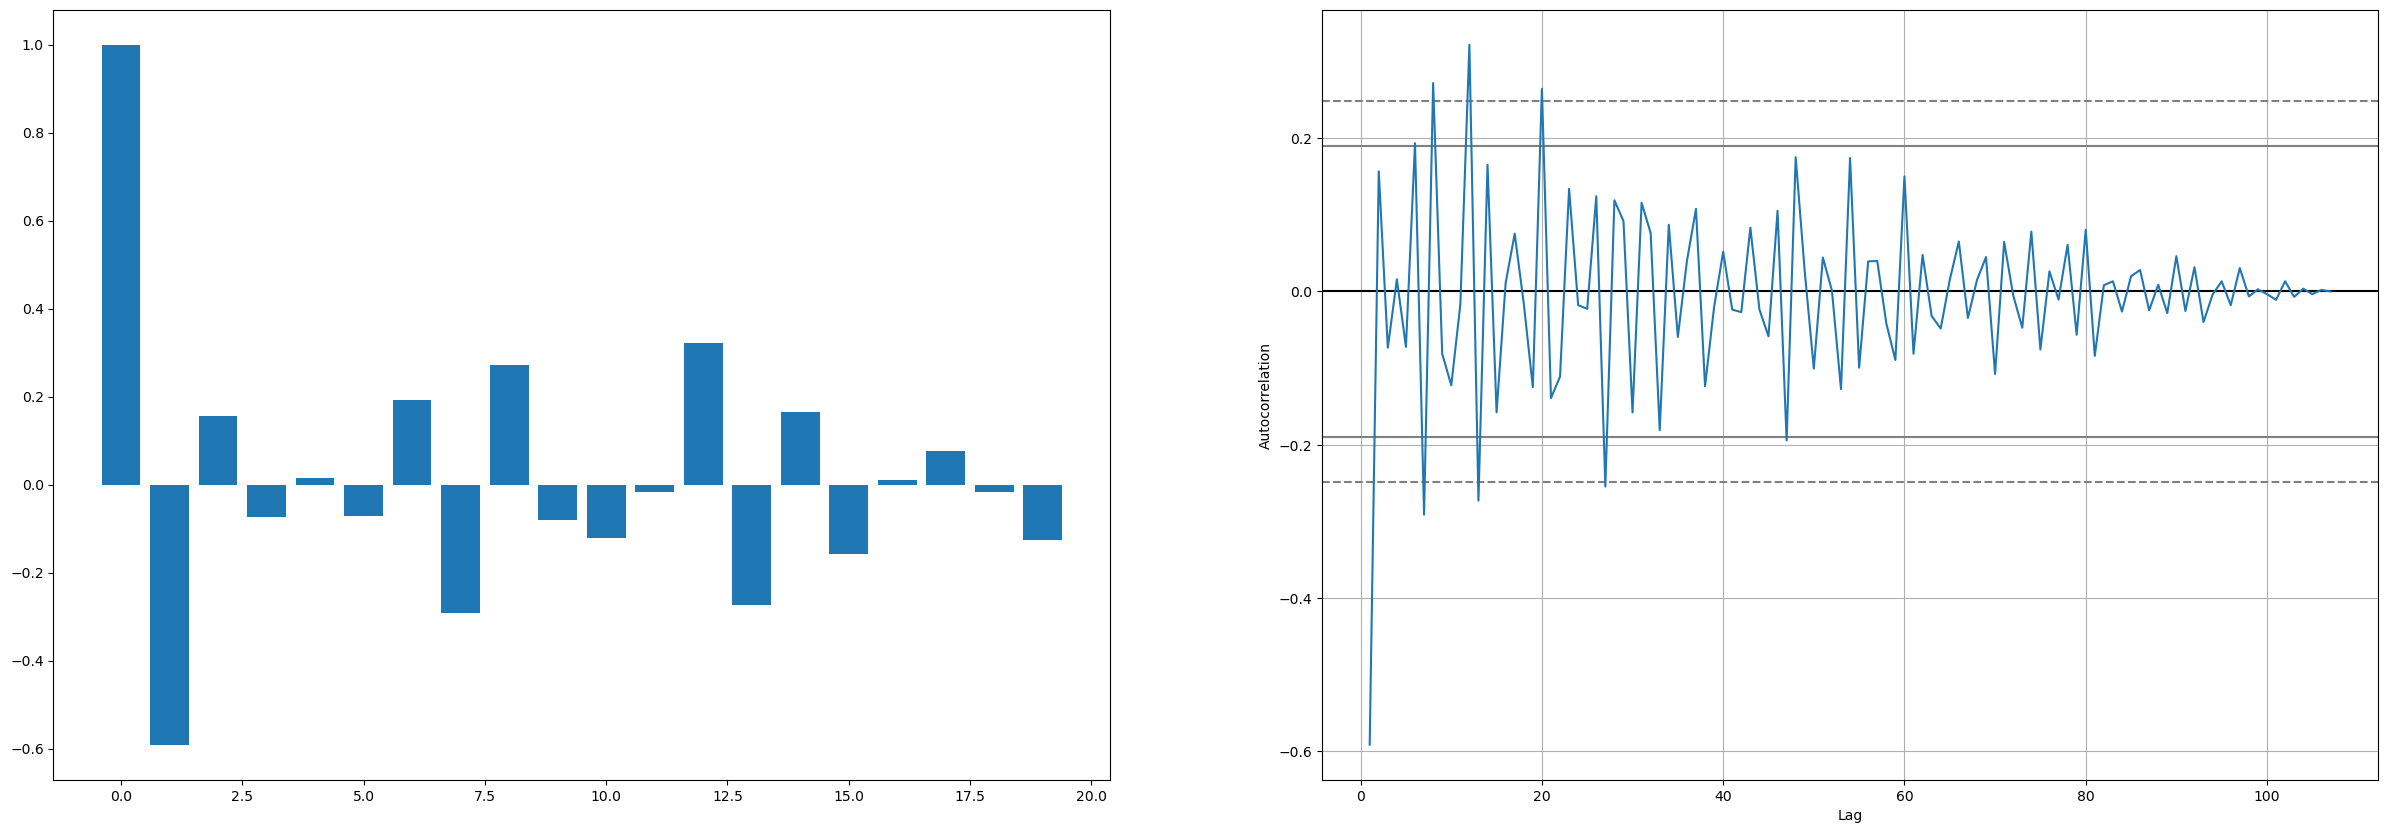

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10))

acf_vals=acf(first_diff)
num_lags= 20
axes[0].bar(range (num_lags),acf_vals[:num_lags])

# Based on ACF, we should start with a seasonal MA process

autocorrelation_plot(first_diff, ax=axes[1])

# It looks like for AR (p) we must choose lag order (1)

#  Selecting the Lag order

# PACF

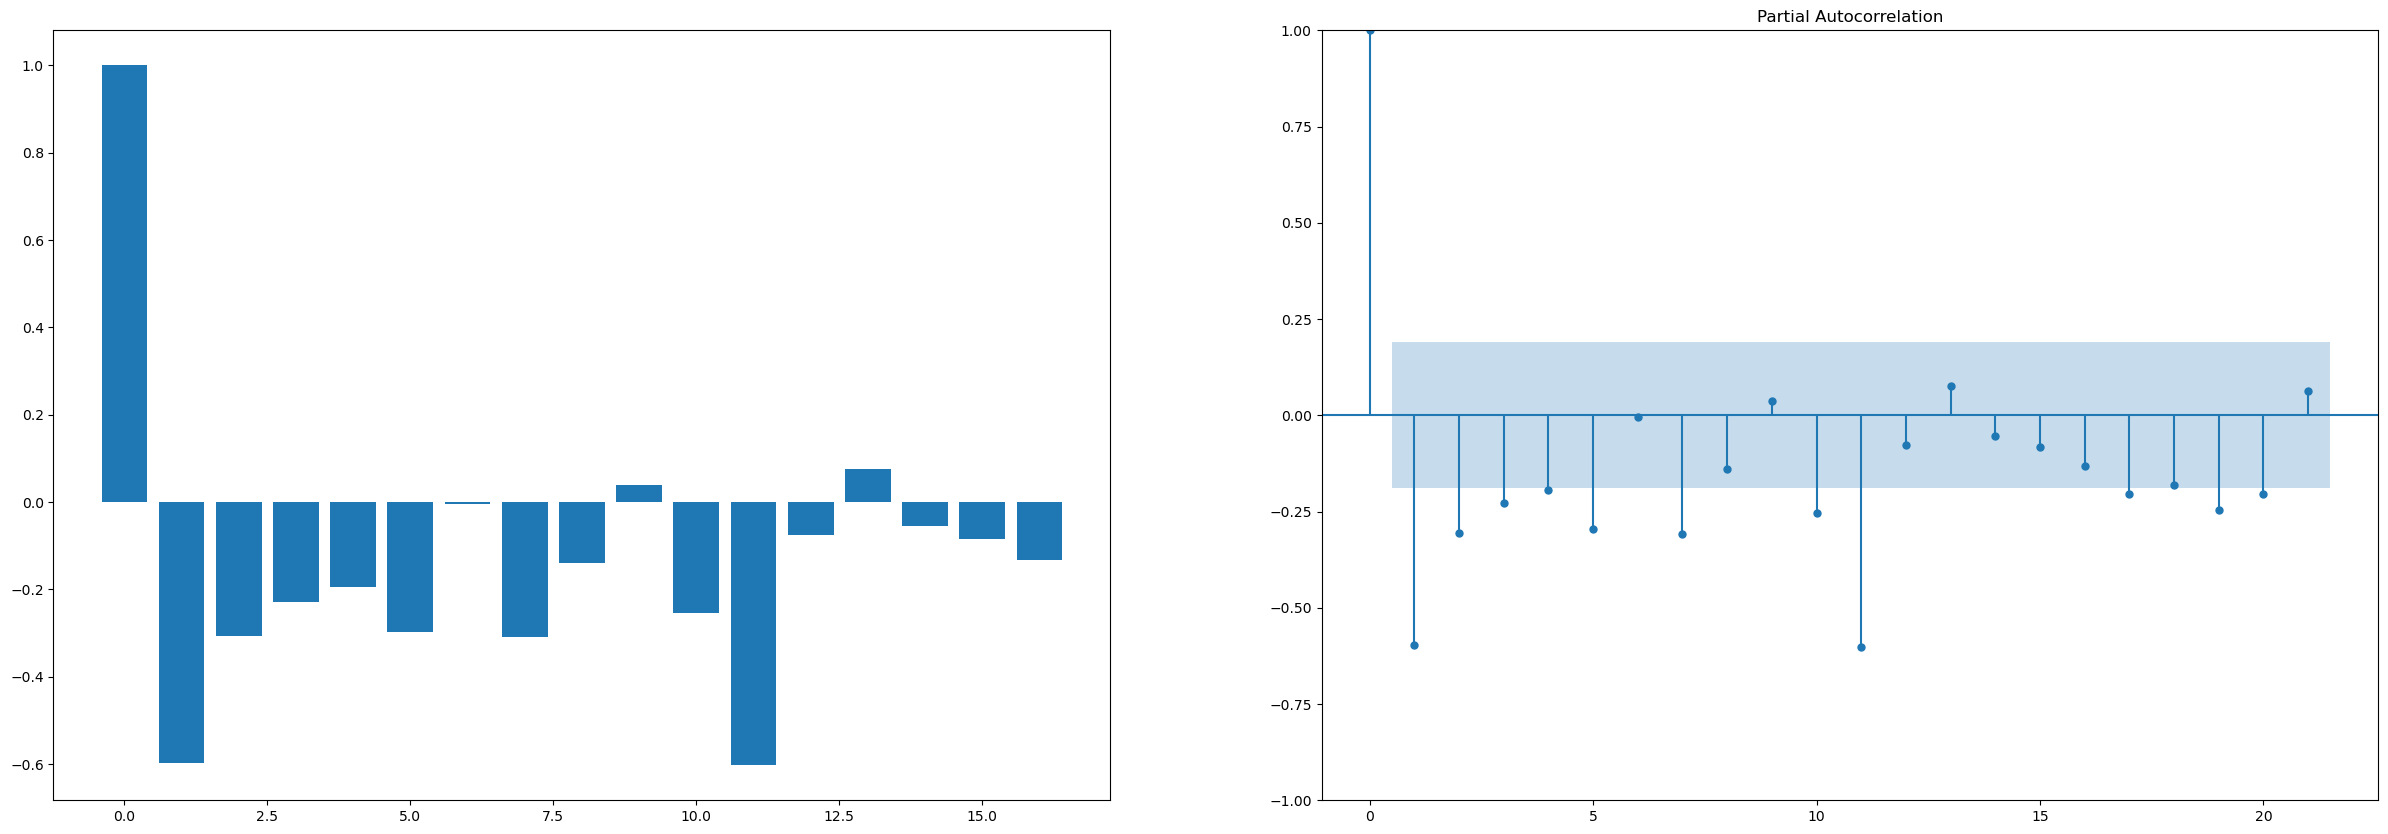

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10))

pacf_vals = pacf(first_diff)
num_lags = 17
axes[0].bar(range(num_lags), pacf_vals[:num_lags])

# Based on PACF, we should start with a seasonal AR process

plot_pacf(first_diff, ax=axes[1]);
# it looks like for MA we should choose lag order (1), (2) or (11)

# Get training and testing sets 


In [38]:
train_end = datetime(2021,12,1)
test_end = datetime(2022,12,1)

train_df = df[:-cutoff_train_test]
test_df = df[-cutoff_train_test:]

print (test_df)




                  Sales
Date                   
2022-01-01  29070464.10
2022-02-01  29367248.57
2022-03-01  28842548.48
2022-04-01  28991351.53
2022-05-01  19438186.76
2022-06-01  30265770.84
2022-07-01  21566475.31
2022-08-01  20211149.29
2022-09-01  30153995.50
2022-10-01  31880398.72
2022-11-01  34237068.90
2022-12-01  26643551.41


# Fit the SARIMA Model on lags chosen based on ACF and PACF

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45971D+01    |proj g|=  1.82369D-01

At iterate    5    f=  1.45114D+01    |proj g|=  2.32507D-03

At iterate   10    f=  1.45113D+01    |proj g|=  1.39638D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   1.396D-05   1.451D+01
  F =   14.511343717288334     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Model Fitting Time: 1.0238614082336426

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

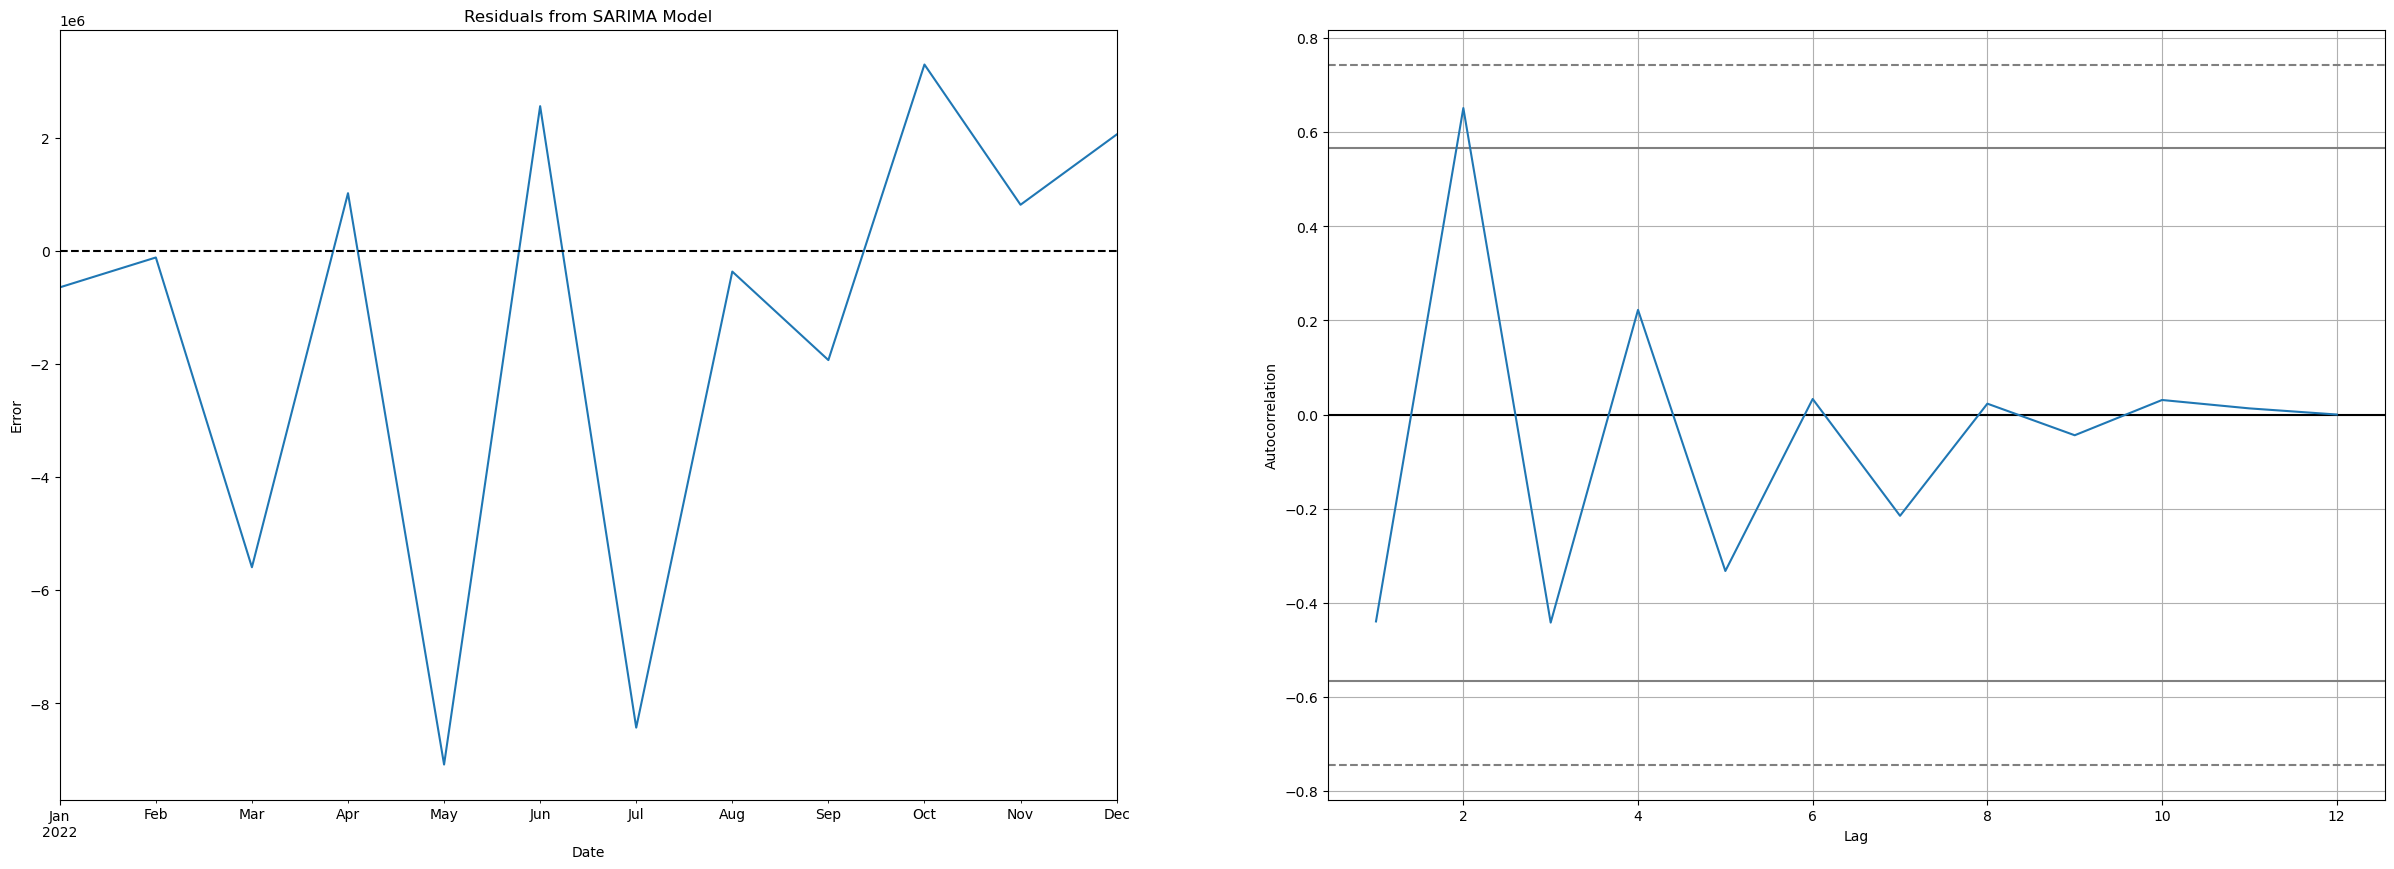

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10))


my_order1 = (1,1,1)
my_seasonal_order1 =(1,1,1,12)

# define model 
model1 = SARIMAX(train_df, order= my_order1, seasonal_order= my_seasonal_order1, freq="MS")

# fit the model1 
start = time()
model_fit1 = model1.fit()
end = time()
print('Model Fitting Time:', end - start)

print(model_fit1.summary())

#get the predictions and residuals
predictions11 = model_fit1.forecast(len(test_df))
predictions1 = pd.Series(predictions11, index=test_df.index)
residuals1 = test_df['Sales'] - predictions1

residuals1.plot(ax=axes[0], title='Residuals from SARIMA Model', ylabel='Error')
axes[0].axhline(0, linestyle='--', color='k')
autocorrelation_plot(residuals1, ax=axes[1])

4208130.426976186 4502516.883681473 4609301.691495028


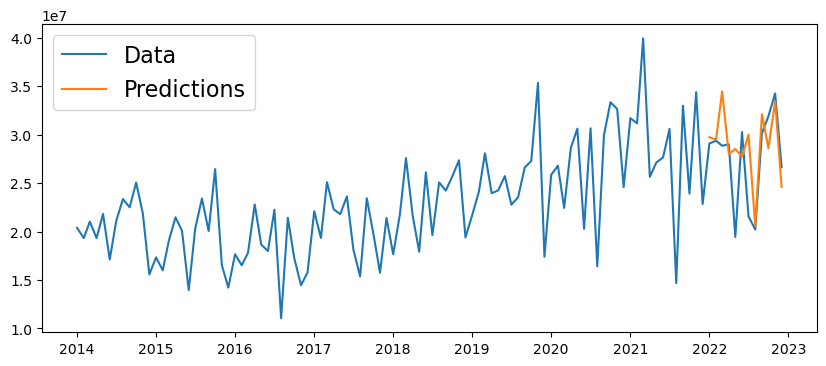

In [46]:
import math
plt.figure(figsize=(10,4))

plt.plot(df["Sales"])
plt.plot(predictions1)
plt.legend(('Data', 'Predictions'), fontsize=16)
mserr = mean_squared_error(predictions11[-12:].values, df["Sales"][-12:].values)
mserr2 = mean_squared_error([2.755568e+07]*12, df["Sales"][-12:].values)
mserr3 = mean_squared_error([train_df["Sales"][-12:].mean()]*12, df["Sales"][-12:].values)

print(math.sqrt(mserr),math.sqrt(mserr2),math.sqrt(mserr3))




# Fit the SARIMA Model based on IC (AIC)

In [47]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    results = []
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [49]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

result_df = optimize_SARIMA(parameters_list, 1, 1, 12, df['Sales'])
result_df.head(10)



  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(3, 3, 0, 3)",3178.892251
1,"(3, 3, 2, 0)",3180.864227
2,"(3, 3, 1, 3)",3180.898913
3,"(3, 3, 2, 2)",3181.006150
4,"(3, 3, 3, 0)",3181.364067
5,"(3, 3, 2, 1)",3181.702709
6,"(2, 3, 0, 3)",3182.075226
7,"(3, 3, 2, 3)",3182.503281
8,"(2, 0, 0, 3)",3182.843864
9,"(3, 3, 0, 1)",3183.703762


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22131D+01    |proj g|=  1.04472D+02

At iterate    5    f=  1.53283D+01    |proj g|=  9.91088D-01

At iterate   10    f=  1.46183D+01    |proj g|=  1.64132D-01

At iterate   15    f=  1.45370D+01    |proj g|=  1.15868D-01

At iterate   20    f=  1.43878D+01    |proj g|=  4.19944D-02

At iterate   25    f=  1.43759D+01    |proj g|=  2.68299D-02

At iterate   30    f=  1.43648D+01    |proj g|=  1.00310D-02

At iterate   35    f=  1.43640D+01    |proj g|=  8.41738D-03

At iterate   40    f=  1.43623D+01    |proj g|=  1.78247D-02

At iterate   45    f=  1.43605D+01    |proj g|=  4.36160D-03

At iterate   50    f=  1.43600D+01    |proj g|=  6.18395D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number

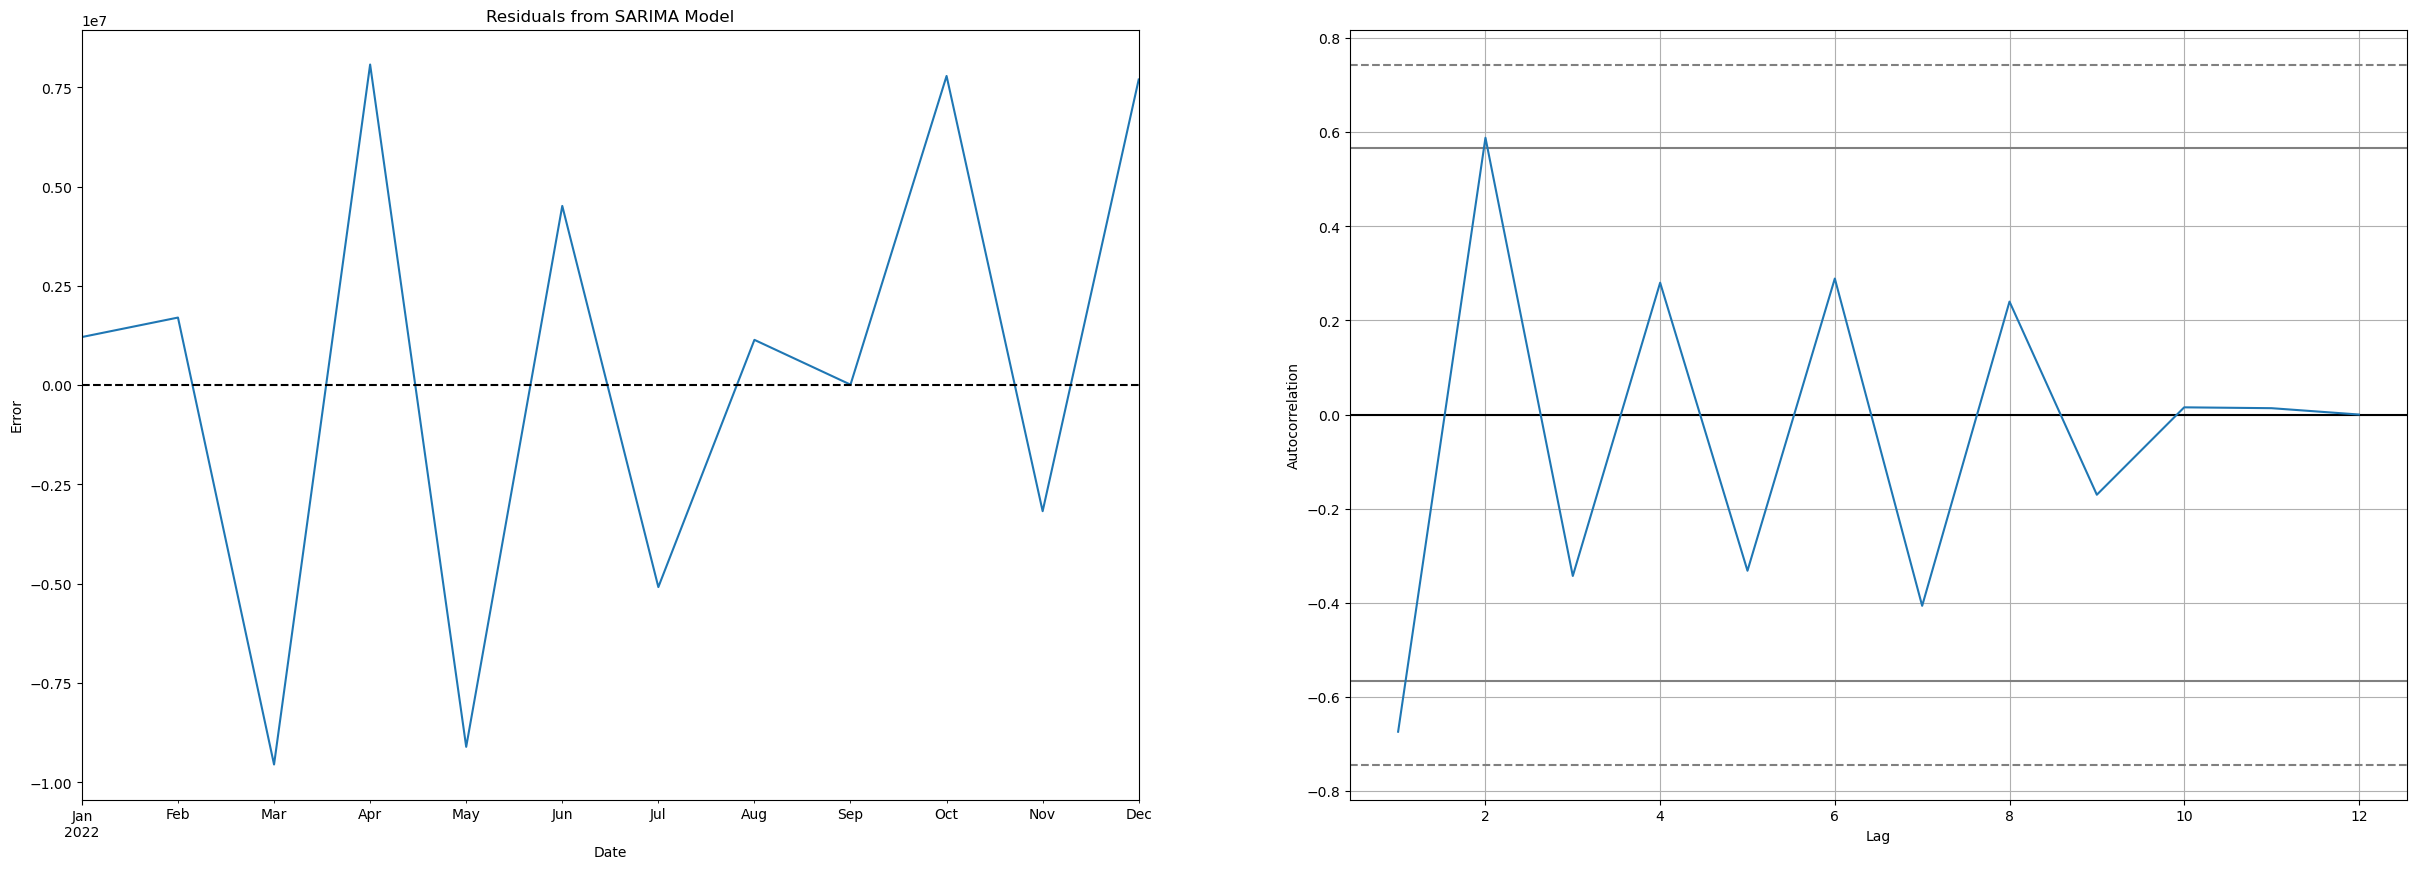

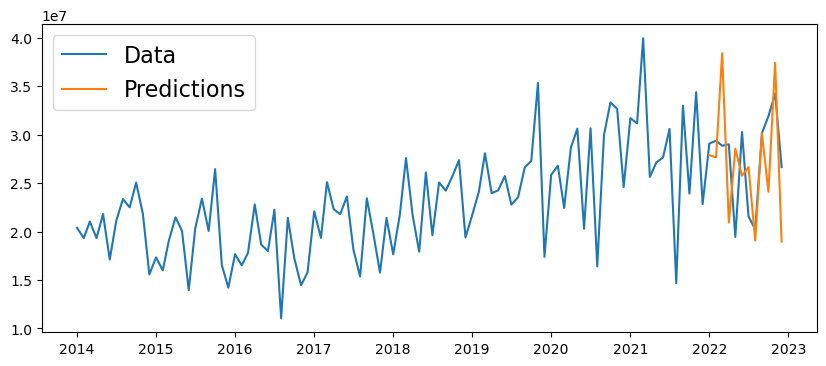

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10))

my_order = (3,1,3)
my_seasonal_order =(3,1,3,12)

# define model 
model = SARIMAX(train_df, order= my_order, seasonal_order= my_seasonal_order, freq="MS")

# fit the model 
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

# summary of the model
print(model_fit.summary())

#get the predictions and residuals
predictions = model_fit.forecast(len(test_df))
predictions = pd.Series(predictions, index=test_df.index)
residuals = test_df['Sales'] - predictions

residuals.plot(ax=axes[0], title='Residuals from SARIMA Model', ylabel='Error')
axes[0].axhline(0, linestyle='--', color='k')
autocorrelation_plot(residuals, ax=axes[1])

plt.figure(figsize=(10,4))

plt.plot(df["Sales"])
plt.plot(predictions)
plt.legend(('Data', 'Predictions'), fontsize=16)
mserr = mean_squared_error(predictions[-12:].values, df["Sales"][-12:].values)

print(math.sqrt(mserr))


In [ ]:
from sklearn.model_selection import ParameterGrid
#[107/360]New best grid! {'ar': 2, 'diff': 1, 'ma': 2, 'seasonality': 12} scoring 3998936.7800536174

params_grid = {
    'ar': [0,1,2,3,4,5], 
    'ar2': [0,1,2,3,4,5], 
    'ma': [0,1,2,3,4,5], 
    'ma2': [0,1,2,3,4,5], 
    'diff': [1,2], 
    'seasonality': [6,12]
} 

grid = ParameterGrid(params_grid)
best_grid=None
best_score = 1e99
nb_grid = len(grid)
iteration = 0
print(f"Running on {nb_grid} parameter combinations")
for param in grid:
    try:
        model = SARIMAX(train_df, order= (param['ar'],param['diff'],param['ma']), seasonal_order= (param['ar2'],param['diff'],param['ma2'],param['seasonality']), freq="MS")
        model_fit = model.fit()
    except:
        print(f"FAILURE for {param}")
        continue
    predictions = model_fit.forecast(len(test_df))
    predictions = pd.Series(predictions, index=test_df.index)
    mserr = mean_squared_error(predictions[-12:].values, df["Sales"][-12:].values)
    score = math.sqrt(mserr)
    if (score < best_score):
        print(f"[{iteration}/{nb_grid}]New best grid! {param} scoring {score}")
        best_score = score
        best_grid = param
    iteration+=1


Running on 5184 parameter combinations
[0/5184]New best grid! {'ar': 0, 'ar2': 0, 'diff': 1, 'ma': 0, 'ma2': 0, 'seasonality': 6} scoring 11531440.14345908
[1/5184]New best grid! {'ar': 0, 'ar2': 0, 'diff': 1, 'ma': 0, 'ma2': 0, 'seasonality': 12} scoring 5798145.174751808
[3/5184]New best grid! {'ar': 0, 'ar2': 0, 'diff': 1, 'ma': 0, 'ma2': 1, 'seasonality': 12} scoring 3993280.7855771356
[305/5184]New best grid! {'ar': 0, 'ar2': 2, 'diff': 1, 'ma': 1, 'ma2': 2, 'seasonality': 12} scoring 3969558.330142741


In this Notebook we built 2 SARIMA forecasting models. 

1st one's parameters were selected by acf and pacf of sales. AIC= 2796  and BIC= 2808, error terms were = 4208130.4301073495 4502516.883681472 4609301.691495025. 
When we plotted the residuals = we could see that residuals tend towards negative values 

2nd model's parameters were chosen by using  optimization model selection tools (IC) AIC. when we use this parameters 
IC= 2783  and BIC= 2814
error terms  = 5963819.568034928 4502516.883681472 4609301.691495025
When we plotted the residuals = we can see an improvement